# DS - Application Project <br>
# Developement of a Recommender System for Employee Skills - Descriptive analysis

## Preprocessing

In [1]:
import pandas as pd
import numpy as np
import random
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
import time
from numpy.random import permutation

Import data:

In [2]:
df = pd.read_csv("data/person-skills_2022-06-27.csv",sep=";") 
df.head(5)

,person,skill,category
0,12,Windows NT/2000/XP,Betriebssystem
1,12,MAC OS X,Betriebssystem
2,12,Windows 7,Betriebssystem
3,12,Windows 8,Betriebssystem
4,12,iOS,Betriebssystem


In [3]:
data_categories = df[["skill","category"]].drop_duplicates()
data_categories.head(5)

,skill,category
0,Windows NT/2000/XP,Betriebssystem
1,MAC OS X,Betriebssystem
2,Windows 7,Betriebssystem
3,Windows 8,Betriebssystem
4,iOS,Betriebssystem


Declaring various aiding variables

In [4]:
PERSONS = df["person"].unique()
SKILLS = sorted(df["skill"].unique())
CATEGORIES = df["category"].unique()
employee_dict = {}
for n in range(0,len(PERSONS)):
    employee_dict[n] = PERSONS[n]


## Descriptive Statistics

Check for each skill how many employees are proficent in that certain skill:

In [5]:
df_value_counts = df.skill.value_counts()
df_value_counts = df_value_counts.to_frame().rename(columns = {"skill" : "number_of_users"}).reset_index(names = "skill")
df_value_counts

,skill,number_of_users
0,Englisch,315
1,MySQL,282
2,SCRUM,276
3,GIT,267
4,HTML,266
...,...,...
729,Final Cut,1
730,Datadog,1
731,Lead Generierung,1
732,Pulumi,1


in percent:

In [6]:
df_value_counts["number_of_users_%"] = df_value_counts.number_of_users/len(df_value_counts.number_of_users/len(df))
df_value_counts

,skill,number_of_users,number_of_users_%
0,Englisch,315,0.429155
1,MySQL,282,0.384196
2,SCRUM,276,0.376022
3,GIT,267,0.363760
4,HTML,266,0.362398
...,...,...,...
729,Final Cut,1,0.001362
730,Datadog,1,0.001362
731,Lead Generierung,1,0.001362
732,Pulumi,1,0.001362


### Plot the number of users for each skill

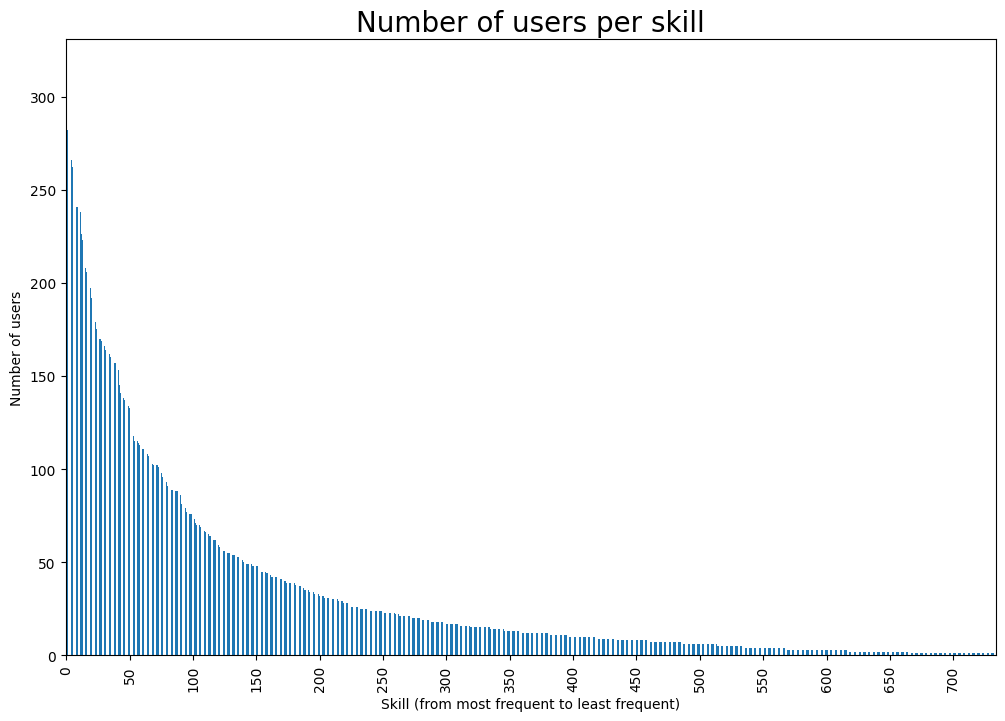

In [7]:
plt.figure(figsize=(12, 8))
ax = df_value_counts.number_of_users.plot(kind="bar")

##########
# Set the indexes as x labels
##########
ax.set_xticklabels(df_value_counts.index)

##########
# Set the x ticks   
##########
ax.set_xticks(np.arange(0,750,50).tolist())

##########
# Set the titles
##########
ax.set_title("Number of users per skill", fontsize=20)
ax.set_xlabel("Skill (from most frequent to least frequent)", fontsize=10)
ax.set_ylabel("Number of users", fontsize=10)
plt.show()

**Description of the plot**

### Plot the number of skills within a category

In [8]:
df_skills_in_categories = df[["skill","category"]].drop_duplicates() 
df_skills_in_categories = df_skills_in_categories.groupby(['category'])["skill"].count().sort_values(ascending= False).to_frame().rename(columns = {"skill" : "number_of_skills"}).reset_index()
df_skills_in_categories.head(5)

,category,number_of_skills
0,Sonstige,98
1,Webentwicklung,57
2,Einsatzfelder / Erfahrungen / Schwerpunkte,47
3,Java Frameworks,43
4,Betriebssystem,37


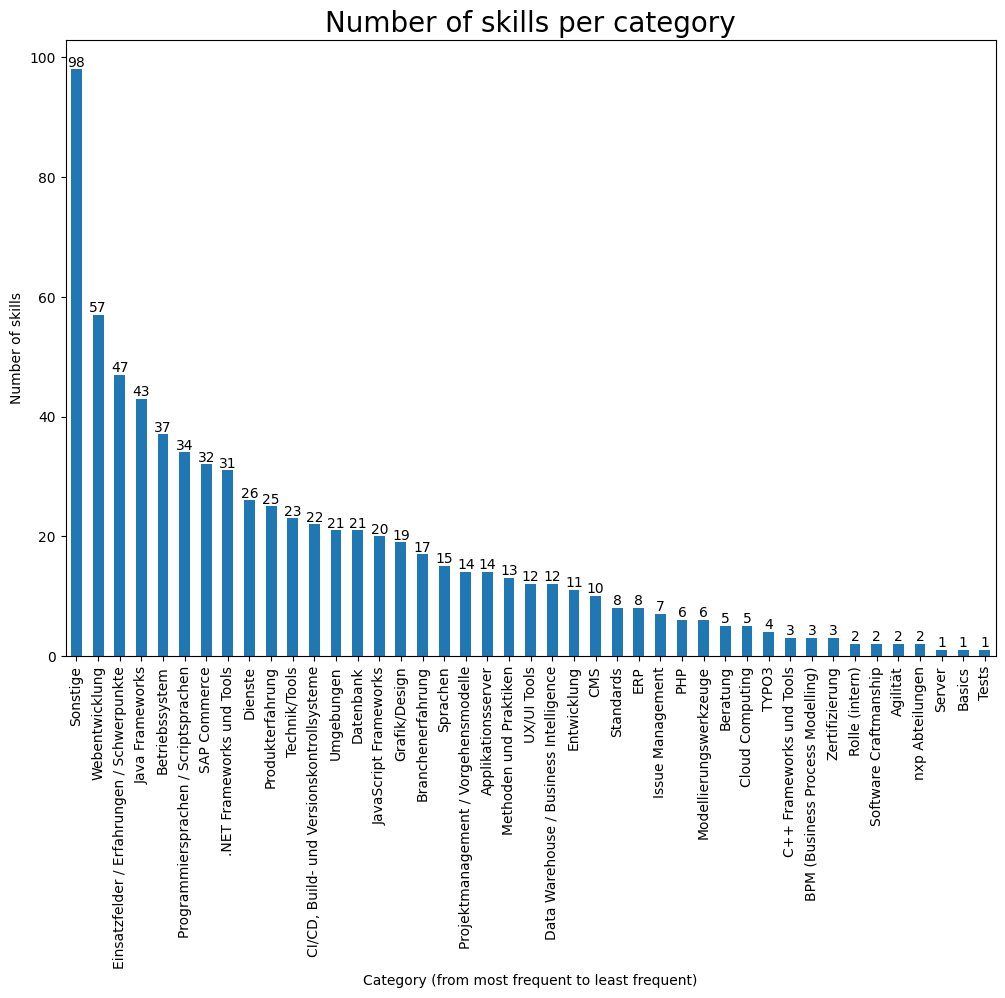

In [9]:
plt.figure(figsize=(12, 8))
ax = df_skills_in_categories.number_of_skills.plot(kind="bar")

# ##########
# # Set the categories as x labels
# ##########
ax.set_xticklabels(df_skills_in_categories.category)

###########
# Set bar labels
###########
rects = ax.patches
for rect, label in zip(rects, df_skills_in_categories.number_of_skills):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height+0.01, label,
        ha='center', va='bottom')

##########
# Set the titles
##########
ax.set_title("Number of skills per category", fontsize=20)
ax.set_xlabel("Category (from most frequent to least frequent)", fontsize=10)
ax.set_ylabel("Number of skills", fontsize=10)
plt.show()

**Description of the plot**

### Categorize the skills by their number of users and plot the distribution

In [10]:
df_categorized = df.groupby(["category", "skill"])["skill"].count().to_frame().rename(columns={"skill": "number_of_users"}).reset_index()
df_categorized.head(5)

,category,skill,number_of_users
0,.NET Frameworks und Tools,.NET Compact Framework,28
1,.NET Frameworks und Tools,.NET Core,10
2,.NET Frameworks und Tools,.NET Framework,87
3,.NET Frameworks und Tools,ADO.NET,23
4,.NET Frameworks und Tools,ASP Generalist,29


In [11]:
graduations = np.array([])

for i in df_categorized.number_of_users:
    if i > 200: 
        
        graduations = np.append(graduations,"> 200")
    elif i >= 100:
        graduations = np.append(graduations,"100 - 200")
    elif i >= 50:
        graduations = np.append(graduations,"50 - 100")
    elif i >= 10:
        graduations = np.append(graduations,"10 - 50")
    else:
        graduations = np.append(graduations,"< 10")

df_categorized["frequence_category"] = graduations
df_categorized

,category,skill,number_of_users,frequence_category
0,.NET Frameworks und Tools,.NET Compact Framework,28,10 - 50
1,.NET Frameworks und Tools,.NET Core,10,10 - 50
2,.NET Frameworks und Tools,.NET Framework,87,50 - 100
3,.NET Frameworks und Tools,ADO.NET,23,10 - 50
4,.NET Frameworks und Tools,ASP Generalist,29,10 - 50
...,...,...,...,...
738,Zertifizierung,CSM – Scrum Master,45,10 - 50
739,Zertifizierung,CSPO – Product Owner,7,< 10
740,Zertifizierung,ISTQB - Foundation Level,10,10 - 50
741,nxp Abteilungen,Pimcore,1,< 10


In [12]:
df_categorized[df_categorized.frequence_category =="> 200"]

,category,skill,number_of_users,frequence_category
121,"CI/CD, Build- und Versionskontrollsysteme",GIT,267,> 200
174,Datenbank,MySQL,282,> 200
179,Datenbank,SQL,241,> 200
231,Einsatzfelder / Erfahrungen / Schwerpunkte,Implementierung,223,> 200
296,Issue Management,JIRA,255,> 200
375,Methoden und Praktiken,Test Driven Development (TDD),241,> 200
376,Methoden und Praktiken,Unit Tests (Komponententests),238,> 200
429,Programmiersprachen / Scriptsprachen,Java,241,> 200
430,Programmiersprachen / Scriptsprachen,JavaScript,262,> 200
457,Projektmanagement / Vorgehensmodelle,SCRUM,276,> 200


Check how often each of our customized categories occurs:

In [13]:
df_categorized = df_categorized.value_counts("frequence_category").to_frame().reset_index().rename(columns={0: "number_of_skills"})
df_categorized

,frequence_category,number_of_skills
0,< 10,324
1,10 - 50,277
2,50 - 100,68
3,100 - 200,57
4,> 200,17


Visualization:

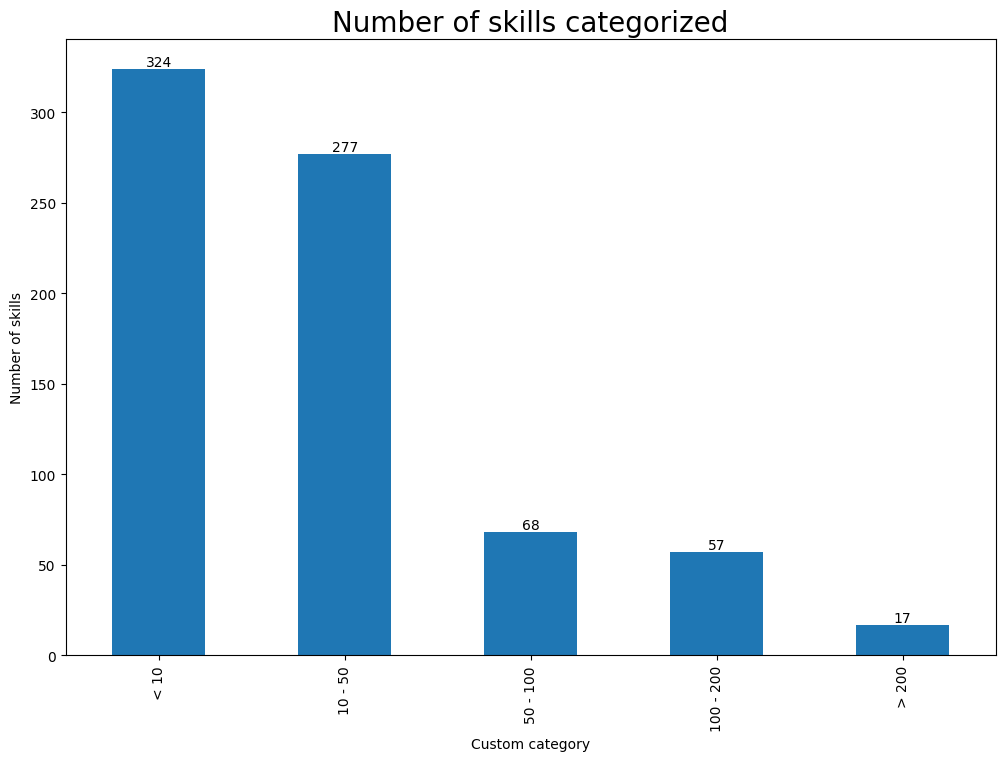

In [15]:
plt.figure(figsize=(12, 8))
ax = df_categorized.number_of_skills.plot(kind="bar")

# ##########
# # Set the categories as x labels
# ##########
ax.set_xticklabels(df_categorized.frequence_category)

###########
# Set bar labels
###########
rects = ax.patches
for rect, label in zip(rects, df_categorized.number_of_skills):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height+0.01, label,
        ha='center', va='bottom')

##########
# Set the titles
##########
ax.set_title("Number of skills categorized", fontsize=20)
ax.set_xlabel("Custom category", fontsize=10)
ax.set_ylabel("Number of skills", fontsize=10)
plt.show()

**Description of the plot**

Books: 

https://www.taylorfrancis.com/books/edit/10.1201/9780367631888/recommender-systems-pavan-kumar-vairachilai-sirisha-potluri-sachi-nandan-mohanty

https://beluga.sub.uni-hamburg.de/vufind/Record/1656091313?rank=1

Drop certain skill categories: 